In [86]:
# SETUP
import numpy as np
import pandas as pd
from osgeo import gdal

from pykrige.ok import OrdinaryKriging

from pykrige.uk import UniversalKriging
import numpy as np
import pykrige.kriging_tools as kt

import matplotlib.pyplot as plt

from scipy.interpolate import interp2d

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# kriging from https://github.com/bsmurphy/PyKrige

In [36]:
def rasterExtract(filename, x, y):
    
    def world2Pixel(gt, x, y):
        ulX = gt[0]
        ulY = gt[3]
        xDist = gt[1]
        yDist = gt[5]
        rtnX = gt[2]
        rtnY = gt[4]
        pixel = int((x - ulX) / xDist)
        line = int((ulY - y) / xDist)
        return (pixel, line)

    dataset = gdal.Open(filename)
    gt = dataset.GetGeoTransform()

    pixel, line = world2Pixel(gt, x, y)

    band = dataset.GetRasterBand(1)
    value = band.ReadAsArray(pixel, line, 1, 1)[0, 0]

    return(value)

In [37]:
# coordinates
coords = pd.read_csv("/Users/Thompson/Desktop/HydroSatML/data/sensor_coords/SCF_TierII_site_coords.csv")
coords_aes = np.array(coords.iloc[0:12,0:2])
coords_aes

array([[  466411.1549,  5182376.04  ],
       [  466497.8643,  5182423.841 ],
       [  466371.5787,  5182249.827 ],
       [  466239.5339,  5182218.854 ],
       [  466275.0262,  5182150.807 ],
       [  466365.6219,  5182132.08  ],
       [  466397.3705,  5182063.394 ],
       [  466420.3849,  5182163.321 ],
       [  466460.1702,  5182182.995 ],
       [  466491.1782,  5182257.467 ],
       [  466491.8605,  5182283.413 ],
       [  466558.3355,  5182171.521 ]])

In [38]:
smr_vals = np.array([])
for i in coords_aes:
    smr_val = rasterExtract("/Users/Thompson/Desktop/HydroSatML/data/SMR/Aes/rz.mc_1592013.asc", i[0], i[1])
    smr_vals = np.append(smr_vals, smr_val)
smr_vals

array([ 0.20970125,  0.21002887,  0.22090527,  0.21401602,  0.21900997,
        0.21856149,  0.21986586,  0.20656858,  0.22804569,  0.21998592,
        0.22340439,  0.21803991])

In [39]:
# monitored data (from joined dataframe)
joined_data = pd.read_csv("/Users/Thompson/Desktop/HydroSatML/data/data_for_models/final_join.csv")

# pull out AES data only
aes_data = joined_data[joined_data.field == "AES"]

# pull out a single date
# aes_data.date.unique()
aes_data = aes_data[aes_data.date == "2013-07-27"]
# NOTE: some dates in original joined data have duplicate values...

# get rid of unnecessary columns and sort on sensor
aes_data = aes_data.iloc[:,0:11]
aes_data = aes_data.sort_values("sensor")
# aes_data

measured_vals = np.mean(aes_data[['depth_1','depth_2','depth_3','depth_4','depth_5']], axis=1)
measured_vals = np.mean(aes_data[['depth_1','depth_2','depth_3']], axis=1)
measured_vals

181    0.233400
180    0.168745
184    0.255447
185    0.275018
189    0.173099
190    0.151764
191    0.180831
188         NaN
186         NaN
183    0.197050
182    0.149060
187    0.167377
dtype: float64

In [40]:
dog = pd.DataFrame()
dog['measured_vals'] = measured_vals
dog['smr_vals'] = smr_vals
dog

,measured_vals,smr_vals
181,0.233400,0.209701
180,0.168745,0.210029
184,0.255447,0.220905
185,0.275018,0.214016
189,0.173099,0.219010
190,0.151764,0.218561
191,0.180831,0.219866
188,NaN,0.206569
186,NaN,0.228046
183,0.197050,0.219986


In [41]:
# get diff between SMR and measured values
vals = measured_vals - smr_vals
vals

181    0.023698
180   -0.041284
184    0.034542
185    0.061002
189   -0.045911
190   -0.066798
191   -0.039035
188         NaN
186         NaN
183   -0.022936
182   -0.074345
187   -0.050663
dtype: float64

In [42]:
# merge coordinates and values and drop rows with NaNs
data = np.c_[coords_aes, vals*100]
data = data[~np.isnan(data).any(axis=1)]
data

array([[  4.66411155e+05,   5.18237604e+06,   2.36983380e+00],
       [  4.66497864e+05,   5.18242384e+06,  -4.12835494e+00],
       [  4.66371579e+05,   5.18224983e+06,   3.45415765e+00],
       [  4.66239534e+05,   5.18221885e+06,   6.10020681e+00],
       [  4.66275026e+05,   5.18215081e+06,  -4.59109071e+00],
       [  4.66365622e+05,   5.18213208e+06,  -6.67977133e+00],
       [  4.66397371e+05,   5.18206339e+06,  -3.90346196e+00],
       [  4.66491178e+05,   5.18225747e+06,  -2.29356688e+00],
       [  4.66491861e+05,   5.18228341e+06,  -7.43448095e+00],
       [  4.66558335e+05,   5.18217152e+06,  -5.06633294e+00]])

In [43]:
# grid for kriged surface

# gridx = np.arange(0.0, 5.5, 0.5)
# gridy = np.arange(0.0, 5.5, 0.5)

ncols = 59
nrows = 54
xllcorner = 466090
yllcorner = 5181980
cellsize = 10

gridx = np.arange(xllcorner+cellsize/2, xllcorner+ncols*cellsize, cellsize)
gridy = np.arange(yllcorner+cellsize/2, yllcorner+nrows*cellsize, cellsize)

# gridx
# gridy

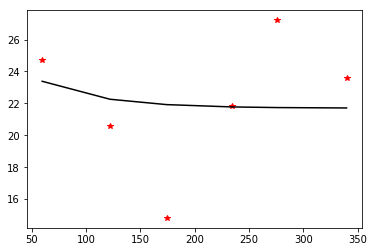

In [48]:
# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. If no variogram model is specified, defaults to a linear variogram
# model. If no variogram model parameters are specified, then the code automatically
# calculates the parameters by fitting the variogram model to the binned
# experimental semivariogram. The verbose kwarg controls code talk-back, and
# the enable_plotting kwarg controls the display of the semivariogram.
OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='exponential',
                     verbose=False, enable_plotting=True)

# variogram_model = linear, power, gaussian, spherical, exponential.
#                   Default is linear variogram model. To utilize as custom variogram
#                   model, specify 'custom'; you must also provide variogram_parameters and
#                   variogram_function.
#                   variogram_parameters (list, optional): Parameters that define the
#                   specified variogram model. If not provided, parameters will be automatically
#                   calculated such that the root-mean-square error for the fit variogram
#                   function is minimized.
#                        linear - [slope, nugget]
#                        power - [scale, exponent, nugget]
#                        gaussian - [sill, range, nugget]
#                        spherical - [sill, range, nugget]
#                        exponential - [sill, range, nugget]

# Creates the kriged grid and the variance grid. Allows for kriging on a rectangular
# grid of points, on a masked rectangular grid of points, or with arbitrary points.
# (See OrdinaryKriging.__doc__ for more information.)
z, ss = OK.execute('grid', gridx, gridy)

# Writes the kriged grid to an ASCII grid file.
kt.write_asc_grid(gridx, gridy, z, filename="output.asc", style=1)

In [67]:
# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. Variogram is handled as in the ordinary kriging case.
# drift_terms is a list of the drift terms to include; currently supported terms
# are 'regional_linear', 'point_log', and 'external_Z'. Refer to
# UniversalKriging.__doc__ for more information.
UK = UniversalKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='gaussian',
                      drift_terms=['regional_linear'], functional_drift=0)

UK = UniversalKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='gaussian',
                      drift_terms=['specified'], specified_drift=list(np.zeros(len(data))))

# Creates the kriged grid and the variance grid. Allows for kriging on a rectangular
# grid of points, on a masked rectangular grid of points, or with arbitrary points.
# (See UniversalKriging.__doc__ for more information.)
z, ss = UK.execute('grid', gridx, gridy)

# Writes the kriged grid to an ASCII grid file.
kt.write_asc_grid(gridx, gridy, z, filename="output.asc", style=1)

ValueError: Must specify the drift values for each data point when using the 'specified' drift capability.

# SPLINE

In [105]:
data[:,2]

array([[  4.66411155e+05,   5.18237604e+06,   2.36983380e+00],
       [  4.66497864e+05,   5.18242384e+06,  -4.12835494e+00],
       [  4.66371579e+05,   5.18224983e+06,   3.45415765e+00],
       [  4.66239534e+05,   5.18221885e+06,   6.10020681e+00],
       [  4.66275026e+05,   5.18215081e+06,  -4.59109071e+00],
       [  4.66365622e+05,   5.18213208e+06,  -6.67977133e+00],
       [  4.66397371e+05,   5.18206339e+06,  -3.90346196e+00],
       [  4.66491178e+05,   5.18225747e+06,  -2.29356688e+00],
       [  4.66491861e+05,   5.18228341e+06,  -7.43448095e+00],
       [  4.66558335e+05,   5.18217152e+06,  -5.06633294e+00]])

array([ 2.3698338 , -4.12835494,  3.45415765,  6.10020681, -4.59109071,
       -6.67977133, -3.90346196, -2.29356688, -7.43448095, -5.06633294])

In [155]:
spline = interp2d(data[:, 0], data[:, 1], data[:, 2], 'linear')

In [194]:
# shows that the function correctly interpolates at all monitored values
for i in range(len(data)):
    print(spline(data[i,0],data[i,1]))

[ 2.3698338]
[-4.12835494]
[ 3.45415765]
[ 6.10020681]
[-4.59109071]
[-6.67977133]
[-3.90346196]
[-2.29356688]
[-7.43448095]
[-5.06633294]


In [196]:
znew = spline(gridx, gridy)
znew.shape

(54, 59)

In [192]:
dog = ("ncols          " + str(ncols) +
       "\nnrows          " + str(nrows) +
       "\nxllcorner      " + str(xllcorner) +
       "\nyllcorner      " + str(yllcorner) +
       "\ncellsize       " + str(cellsize))

np.savetxt("dog.txt", znew, header=dog, comments="")

NameError: name 'smr' is not defined

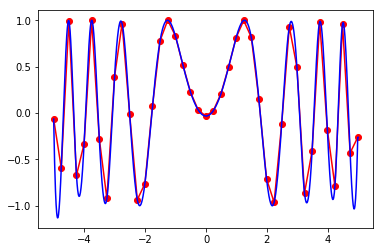

In [89]:
from scipy import interpolate
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')

# Now use the obtained interpolation function and plot the result:

xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)
znew = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

# SAMPLE

In [ ]:
# EXAMPLE FROM https://github.com/bsmurphy/PyKrige
from pykrige.ok import OrdinaryKriging
import numpy as np
import pykrige.kriging_tools as kt

data = np.array([[0.3, 1.2, 0.47],
                 [1.9, 0.6, 0.56],
                 [1.1, 3.2, 0.74],
                 [3.3, 4.4, 1.47],
                 [4.7, 3.8, 1.74]])

gridx = np.arange(0.0, 5.5, 0.5)
gridy = np.arange(0.0, 5.5, 0.5)

# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. If no variogram model is specified, defaults to a linear variogram
# model. If no variogram model parameters are specified, then the code automatically
# calculates the parameters by fitting the variogram model to the binned
# experimental semivariogram. The verbose kwarg controls code talk-back, and
# the enable_plotting kwarg controls the display of the semivariogram.
OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='linear',
                     verbose=False, enable_plotting=False)

# Creates the kriged grid and the variance grid. Allows for kriging on a rectangular
# grid of points, on a masked rectangular grid of points, or with arbitrary points.
# (See OrdinaryKriging.__doc__ for more information.)
z, ss = OK.execute('grid', gridx, gridy)

# Writes the kriged grid to an ASCII grid file.
kt.write_asc_grid(gridx, gridy, z, filename="output.asc")